# 20240615 3次関数の回帰分析(nutpie)

サンプリング速度を改善するために nutpie を使用します。\
2024-04-22 に作成したコードと速度を比較します。

2024-07-12\
timeコマンドの繰り返しの視認性が悪いので、繰り返し回数を1回に変更した。\

1. pymc(デフォルト)\
CPU times: total: 7.72 s\
Wall time: 1min 2s

2. nutpie\
CPU times: total: 12.2 s\
Wall time: 12.4 s

最初に,必要なライブラリをインポートします.

In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import nutpie

import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

グラフのスタイルや乱数の種を初期化します.

In [2]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## 問題設定

今回も,$y = \frac{x^3}{3} - x$に正規分布のノイズを加えたデータセットの回帰問題に挑戦します.\
ただし,データ数は20個に減らします.

データの分布を図1に示します.

(-3.0, 3.0)

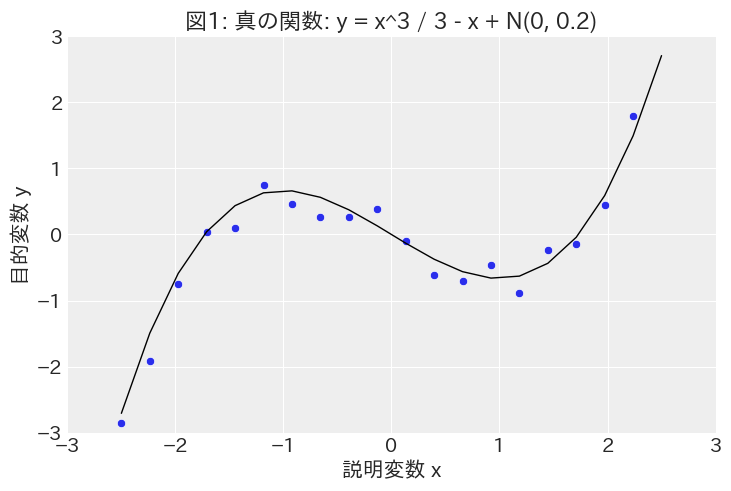

In [3]:
x = np.linspace(-2.5, +2.5, 20)
noise = np.random.normal(loc = 0.0, scale = 0.2, size = x.shape[0])
y = x ** 3 / 3.0 - x + noise


plt.plot(x, y - noise, linewidth = 1, alpha = 1, c = "black")
sns.scatterplot(x = x, y = y)

plt.title("図1: 真の関数: y = x^3 / 3 - x + N(0, 0.2)")
plt.xlabel("説明変数 x")
plt.ylabel("目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

$x < 1$のデータを訓練データセット, $x \geq 1$のデータをテストデータセットとします.\
今回の問題は,$x < 1$のデータを用いて,$x \geq 1$の目的変数を予測することとなります.

図2は訓練データセットの散布図です.\
切り取られた右端のデータセットを予測することが,今回の課題になります.

(-3.0, 3.0)

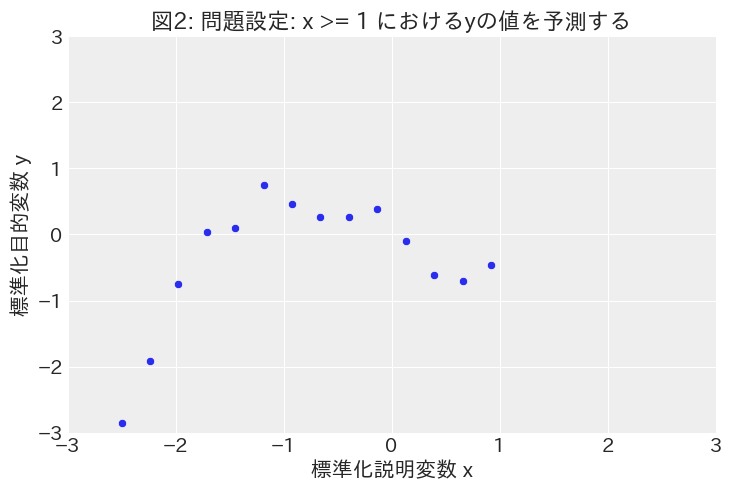

In [4]:
x_train, x_test = x[ x < 1 ], x[ x >= 1]
y_train, y_test = y[ x < 1 ], y[ x >= 1]

sns.scatterplot(x = x_train, y = y_train)
plt.title("図2: 問題設定: x >= 1 におけるyの値を予測する")
plt.xlabel("標準化説明変数 x")
plt.ylabel("標準化目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

## モデル定義
タイトルに答えが書いてありますが,一応3次関数でモデルを作成する理由を書いておきましょう.

1. 散布図のピークが1つだけ見えるので,2次関数か3次関数で近似するのが無難.
1. 標準化したデータの散布図が線対称ではないので,3次関数を選択する.
    * $x = -3, 1$の目的変数の値が倍以上異なる.

したがって,今回の確率モデルは下記の式で表されます.
$$
\begin{align}
y &\sim \mathcal{N} \bigl( \mu , \sigma ^2 \bigr)\\
\mu &= \beta _0 + \beta _1 x + \beta _2 x^2 + \beta _3 x^3\\
\sigma &\sim \mathcal{HN} \bigl(1)\\
\beta _i &\sim \mathcal{N} \bigl( 0 , 1)
\end{align}
$$

ここで,$\alpha$は3次関数の切片,$\beta _i$は係数です.
$\alpha$と$\beta _i$は標準正規分布,$\sigma$標準半正規分布と仮定します(事前分布).
この確率モデルをプログラミングすると,次のセルの通りになります.

In [5]:
# 特徴量の標準化用定数
x_mean = x_train.mean()
x_std = x_train.std()

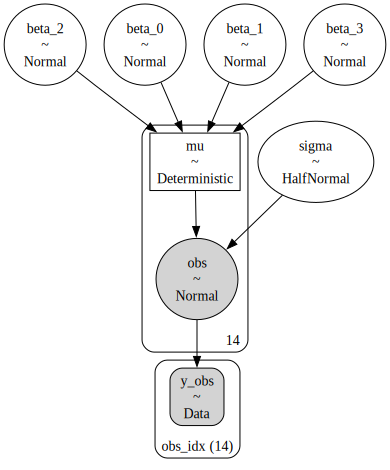

In [6]:
# 観測値を使って別の変数を作成すると nutpie のShared variable error が発生するので、モデルを定義する前に計算しておく。
x_standardized = (x_train - x_mean) / x_std

# モデル定義
with pm.Model(coords = {"obs_idx": range(0, len(x_train))}) as model:
    # 観測値
    #x_obs = pm.Data("x_obs", value = x_train, dims = ["obs_idx"])
    y_obs = pm.Data("y_obs", value = y_train, dims = ["obs_idx"])

    # 標準化
    #x_standardized = (x_obs - x_mean) / x_std

    # 3次関数の係数
    beta_0 = pm.Normal("beta_0", mu = 0, sigma = 10)
    beta_1 = pm.Normal("beta_1", mu = 0, sigma = 10)
    beta_2 = pm.Normal("beta_2", mu = 0, sigma = 10)
    beta_3 = pm.Normal("beta_3", mu = 0, sigma = 10)
    
    # 目的変数の誤差の確率分布
    mu = pm.Deterministic("mu", beta_0 + beta_1 * x_standardized + beta_2 * x_standardized ** 2 + beta_3 * x_standardized ** 3)
    sigma = pm.HalfNormal("sigma", sigma = 10)
    pm.Normal("obs", mu = mu, sigma = sigma, observed = y_obs)

# モデル構造の可視化
pm.model_to_graphviz(model)

### 事後分布の生成

モデル構造が設計どおりであることを確認したら,次はMCMCに基づく事後分布の生成を行います.

In [7]:
%%time
with model:
    # 乱数シードの初期化
    RANDOM_SEED = 58
    rng = np.random.default_rng(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    # 事後分布の生成
    idata = pm.sample(draws = 1000, tune = 1000, chains = 2, target_accept = 0.95, random_seed = rng, nuts_sampler = "nutpie")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.30,15
,2000,0,0.30,23


CPU times: total: 12.2 s
Wall time: 12.4 s


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.30,15
,2000,0,0.30,23


array([[<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>]], dtype=object)

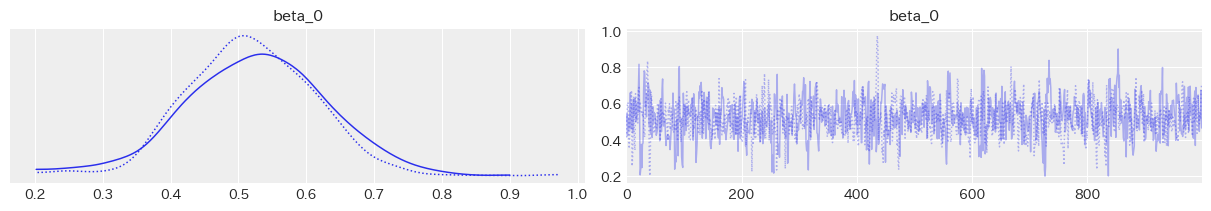

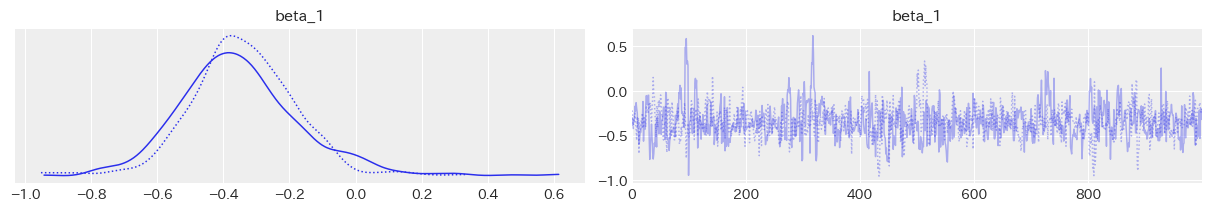

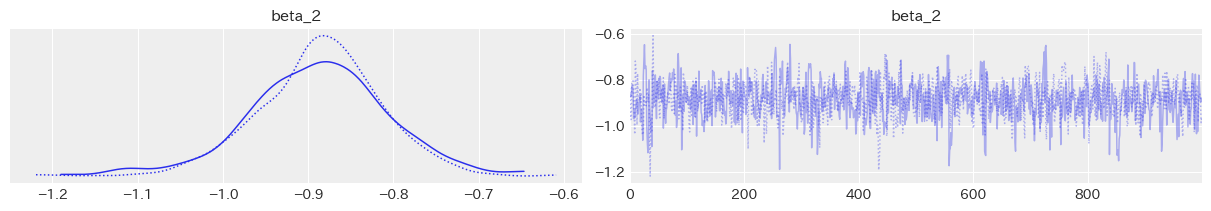

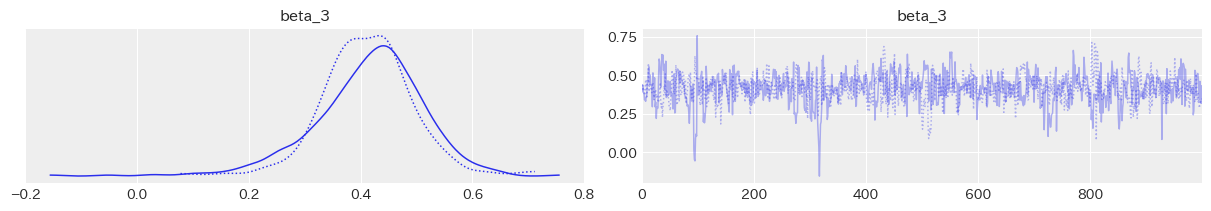

In [8]:
with model:
    # 乱数シードの初期化
    RANDOM_SEED = 58
    rng = np.random.default_rng(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    # 事後分布の生成
    idata = pm.sample(draws = 1000, tune = 1000, chains = 2, target_accept = 0.95, random_seed = rng, nuts_sampler = "nutpie")

# サンプリングトレースの可視化
az.plot_trace(idata, var_names = ["beta_0"])
az.plot_trace(idata, var_names = ["beta_1"])
az.plot_trace(idata, var_names = ["beta_2"])
az.plot_trace(idata, var_names = ["beta_3"])

サンプリングトレースが問題ないことを確認したら,モデルの評価に移ります.

判断基準
* 左側の分布が1箇所に収束している.
    * ただし,予測値$\mu$の分布は無視する.
* 右側の分布に黒い縦線(発散)が無い.

## モデルの評価

パラメータ推定値の分布から,モデルを評価します.

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

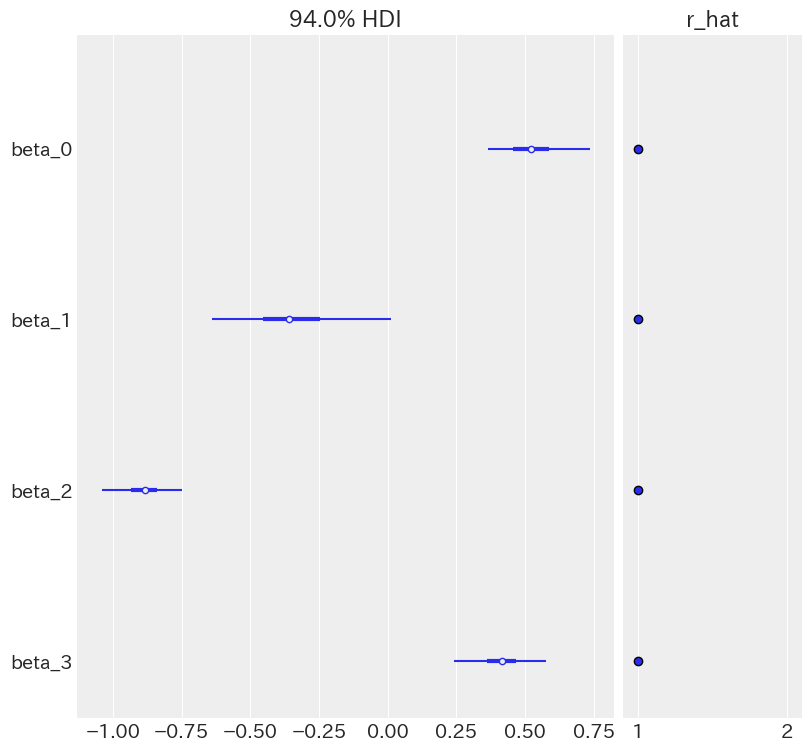

In [9]:
az.plot_forest(idata, combined = True, var_names = ["beta_0", "beta_1", "beta_2", "beta_3"], r_hat = True)

```r_hat```が1に近いとパラメータ推定は安定していると考えられます.

また,パラメータ推定値は真の関数$y = \frac{x^3}{3} - x$の係数とほぼ同じ値を指しました.

## データの予測

テストデータの予測値を算出します

In [10]:
# 標準化
x_standardized = (x - x_mean) / x_std

# 係数
# 描画時間短縮のため,サンプリングの終盤の20個で予測する
beta_0 = idata["posterior"]["beta_0"].values.reshape(-1, 1)[-20:]
beta_1 = idata["posterior"]["beta_1"].values.reshape(-1, 1)[-20:]
beta_2 = idata["posterior"]["beta_2"].values.reshape(-1, 1)[-20:]
beta_3 = idata["posterior"]["beta_3"].values.reshape(-1, 1)[-20:]

# 予測値分布
y_preds = (
    beta_0 * np.ones(len(x_standardized))
    + beta_1 * x_standardized
    + beta_2 * x_standardized ** 2
    + beta_3 * x_standardized ** 3
)

テストデータの予測値をプロットします.

(-3.0, 3.0)

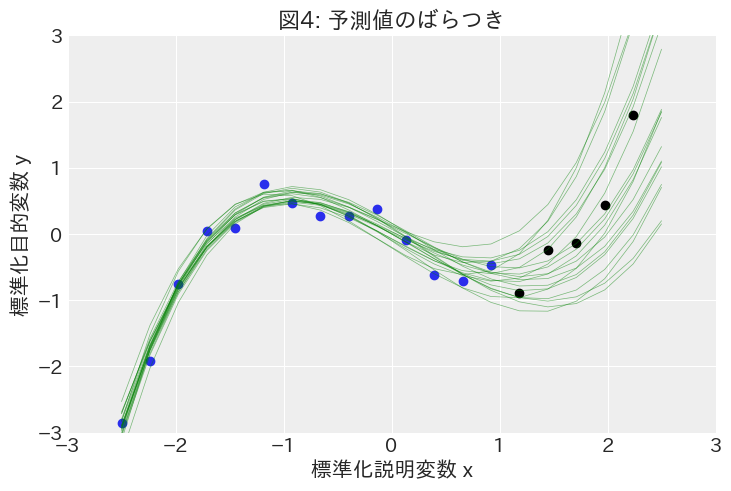

In [11]:
_, ax = plt.subplots()

# 予測分布
for y_pred in y_preds:
    plt.plot(x, y_pred, linewidth = 0.5, alpha = 0.5, c = "green")

# 訓練データ
ax.scatter(x_train, y_train)
ax.scatter(x_test, y_test, marker = "o", color = "k")

ax.set_title("図4: 予測値のばらつき")
ax.set_xlabel("標準化説明変数 x")
ax.set_ylabel("標準化目的変数 y")
plt.xlim(-3, 3)
plt.ylim(-3, 3)